In [217]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [218]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [219]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [220]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [221]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [222]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [223]:
ratings['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

In [224]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [225]:
tags['tag'].value_counts()

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
surreal               23
                    ... 
test tag               1
dumpster diving        1
Moving                 1
Jesse Eisenberg        1
Ghosts                 1
Name: tag, Length: 1589, dtype: int64

In [226]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [227]:
movie_genres = [change_string(g) for g in movies.genres.values]

In [228]:
movie_mod = movies.copy()

In [229]:
movie_mod['genres_list'] = [change_string(g) for g in movies['genres']]

In [230]:
movie_mod.drop(['genres'], axis = 1, inplace = True)

In [231]:
movie_mod.head(3)

,movieId,title,genres_list
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [232]:
movie_mod.shape

(9742, 3)

In [233]:
tags_mod = tags[['movieId','tag']].groupby(['movieId'])['tag'].apply(list).reset_index()
tags_ = tags_mod.copy()
tags_mod['tags_list'] = tags_mod['tag'].apply(lambda x: ' '.join(set(x)))
tags_mod.drop(['tag'], axis = 1, inplace=True)
tags_mod.drop_duplicates(inplace=True)
tags_mod

,movieId,tags_list
0,1,fun pixar
1,2,fantasy game magic board game Robin Williams
2,3,moldy old
3,5,pregnancy remake
4,7,remake
...,...,...
1567,183611,funny Comedy Rachel McAdams
1568,184471,Alicia Vikander adventure video game adaptation
1569,187593,sarcasm Ryan Reynolds Josh Brolin
1570,187595,Emilia Clarke star wars


In [234]:
movie_with_tags = pd.merge(movie_mod, tags_mod, on = ['movieId'], how = 'left')

In [235]:
movie_with_tags.fillna('', inplace = True)
movie_with_tags

,movieId,title,genres_list,tags_list
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy game magic board game Robin Williams
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old
3,4,Waiting to Exhale (1995),Comedy Drama Romance,
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,
9739,193585,Flint (2017),Drama,
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,


Удалим редко встречающиеся слова. Для этого посмотрим на частоту встречающихся слов с помощью CountVectorizer. построим вектор с частотой встречающихся слов, где индекс массива - это слово, а значение - частота. Как видим, слова, встречающиеся в корпусе 1 раз составляют 968 слов, что есть больше половины всего словаря. С помощью парамета min_df установим минимальную частоту для слов в словаре 2 шт. то есть в словарь попадают только слова с частотой >=2

In [236]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
freq_matrix = count_vect.fit_transform(tags_mod['tags_list'])
freq_vector = np.sum(freq_matrix.toarray(), axis = 0)
freq_vector

array([3, 1, 2, ..., 2, 5, 1], dtype=int64)

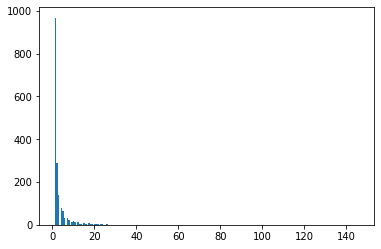

In [237]:
import matplotlib.pyplot as plt
plt.hist(freq_vector, bins = 200)
plt.show()

In [238]:
#проверим сколько слов добавляет в словарь TfidfVectorizer при min_df = 2
tfidf_tag1 = TfidfVectorizer(min_df = 2)
tfidf_tag1.fit(movie_with_tags['tags_list'])
len(list(tfidf_tag1.vocabulary_.values()))

765

In [239]:
#количество слов с частотой 1
count = 0
for i in freq_vector:
    if i == 1:
        count +=1
count

968

In [240]:
tfidf_gen = TfidfVectorizer()
tfidf_gen.fit(movie_with_tags['genres_list'])
tfidf_tag = TfidfVectorizer(min_df = 2)
tfidf_tag.fit(movie_with_tags['tags_list'])

TfidfVectorizer(min_df=2)

In [241]:
with_ratings = movie_with_tags.merge(ratings).drop(['timestamp'], axis = 1)

In [242]:
with_ratings

,movieId,title,genres_list,tags_list,userId,rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,1,4.0
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,5,4.0
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,7,4.5
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,15,2.5
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,17,4.5
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,,184,4.0
100832,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,,184,3.5
100833,193585,Flint (2017),Drama,,184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,,184,3.5


In [243]:
with_ratings['userId'].value_counts().head(5)

414    2698
599    2478
474    2108
448    1864
274    1346
Name: userId, dtype: int64

In [244]:
user599 = with_ratings[with_ratings['userId'] == 599]
user599

,movieId,title,genres_list,tags_list,userId,rating
204,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun pixar,599,3.0
319,2,Jumanji (1995),Adventure Children Fantasy,fantasy game magic board game Robin Williams,599,2.5
375,3,Grumpier Old Men (1995),Comedy Romance,moldy old,599,1.5
530,6,Heat (1995),Action Crime Thriller,,599,4.5
586,7,Sabrina (1995),Comedy Romance,remake,599,2.5
...,...,...,...,...,...,...
100669,179817,Darkest Hour (2017),Drama War,,599,3.0
100690,180031,The Shape of Water (2017),Adventure Drama Fantasy,atmospheric dreamlike,599,3.5
100699,180297,The Disaster Artist (2017),Comedy Drama,,599,3.0
100712,181315,Phantom Thread (2017),Drama Romance,,599,3.5


In [245]:
user599_gen = tfidf_gen.transform(user599['genres_list'])
user599_tag = tfidf_tag.transform(user599['tags_list'])

In [246]:
print('Shape of user599_gen: ', user599_gen.shape, ' Shape of user599_tag: ', user599_tag.shape)

Shape of user599_gen:  (2478, 20)  Shape of user599_tag:  (2478, 765)


In [247]:
y = user599['rating']
X = np.hstack((user599_gen.toarray(), user599_tag.toarray()))
X.shape

(2478, 785)

In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [250]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [251]:
#linear regression quality
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_test, lr.predict(X_test))
r2 = r2_score(y_test, lr.predict(X_test))

rmse_train = mean_squared_error(y_train, lr.predict(X_train))
r2_train = r2_score(y_train, lr.predict(X_train))
print('Train dataset: Mean squaed error:  ', rmse_train, ', R2: ', r2_train) 
print('Test dataset: Mean squaed error:  ', rmse, ', R2: ', r2)

Train dataset: Mean squaed error:   0.4192530830559027 , R2:  0.36778069027917115
Test dataset: Mean squaed error:   1.9427822589719467e+23 , R2:  -2.9110042288668167e+23


In [252]:
#Random Forest Regression quality
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_test, rfr.predict(X_test))
r2 = r2_score(y_test, rfr.predict(X_test))

rmse_train = mean_squared_error(y_train, rfr.predict(X_train))
r2_train = r2_score(y_train, rfr.predict(X_train))
print('Train dataset: Mean squaed error:  ', rmse_train, ', R2: ', r2_train) 
print('Test dataset: Mean squaed error:  ', rmse, ', R2: ', r2)

Train dataset: Mean squaed error:   0.31045216505950657 , R2:  0.5318487533481366
Test dataset: Mean squaed error:   0.6533811284717433 , R2:  0.020994133923433966


In [253]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


knn = KNeighborsRegressor()
svr = SVR()
las = Lasso()
ri = Ridge()
rf = RandomForestRegressor()

param_knn = {'n_neighbors': range(1,11)}
param_svr = {'kernel': ['poly', 'rbf']}
param_la  = {'alpha': [.0001, .001, .01, .5, 10.]}
param_ri  = {'alpha': [0.1, 0.2, 0.5, 1.0, 5., 10.]}
param_rf  = {
                'max_depth': [10],
                'min_samples_leaf': range(2, 19, 4),
            }

In [254]:
best_estimators = []
for reg, param in zip([knn, svr, las, ri, rf], [param_knn, param_svr, param_la, param_ri, param_rf]):
    grid = GridSearchCV(reg, param, cv=10, scoring='r2')
    grid.fit(X_train, y_train)
    print(reg.__class__.__name__, ':', grid.best_params_,"\t", 'acc:', grid.best_score_)
    best_estimators.append(grid.best_estimator_)

KNeighborsRegressor : {'n_neighbors': 9} 	 acc: 0.05653107808597594
SVR : {'kernel': 'rbf'} 	 acc: 0.1710412877246764
Lasso : {'alpha': 0.001} 	 acc: 0.11329376246131151
Ridge : {'alpha': 1.0} 	 acc: 0.14270269343830105
RandomForestRegressor : {'max_depth': 10, 'min_samples_leaf': 6} 	 acc: 0.10095047722491432


In [255]:
from sklearn.metrics import r2_score
r2_score(y_test, best_estimators[1].predict(X_test))

0.1722909330382133

Вывод: лучшее качество дает метод SVR с R2= 0.17. это очень низкий показатель. Отконение будет примерно 0.6 оценки. Также ниже пробовал только на жанрах спрогнозиовать оценку. Резульат получился чуть х

In [256]:
matrix_genres = tfidf_tag.transform(movie_with_tags['genres_list'])

In [257]:
matrix_genres.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [258]:
cnt_vec = CountVectorizer()
words = cnt_vec.fit_transform(movie_genres)
tfidf = TfidfTransformer()
words_tfidf = tfidf.fit_transform(words)

In [259]:
cnt_vec.vocabulary_

{'adventure': 1,
 'animation': 2,
 'children': 3,
 'comedy': 4,
 'fantasy': 8,
 'romance': 15,
 'drama': 7,
 'action': 0,
 'crime': 5,
 'thriller': 17,
 'horror': 10,
 'mystery': 13,
 'scifi': 16,
 'war': 18,
 'musical': 12,
 'documentary': 6,
 'imax': 11,
 'western': 19,
 'filmnoir': 9,
 'nogenreslisted': 14}

In [260]:
words.toarray()

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [261]:
words.shape

(9742, 20)

In [262]:
words_tfidf.toarray()

array([[0.        , 0.41684567, 0.51622547, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.51236121, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.57860574, 0.        , 0.81560738, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [263]:
movie_rating = movie_mod.merge(ratings)

In [264]:
movie_rating_user599 = movie_rating[movie_rating['userId'] == 599]

In [265]:
movie_rating_user599.head(3)

,movieId,title,genres_list,userId,rating,timestamp
204,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,599,3.0,1498524204
319,2,Jumanji (1995),Adventure Children Fantasy,599,2.5,1498514085
375,3,Grumpier Old Men (1995),Comedy Romance,599,1.5,1498505071


In [266]:
 movie_rating_user599['rating']

204       3.0
319       2.5
375       1.5
530       4.5
586       2.5
         ... 
100669    3.0
100690    3.5
100699    3.0
100712    3.5
100736    3.0
Name: rating, Length: 2478, dtype: float64

In [267]:
movie_rating_user599['genres_list']

204       Adventure Animation Children Comedy Fantasy
319                        Adventure Children Fantasy
375                                    Comedy Romance
530                             Action Crime Thriller
586                                    Comedy Romance
                             ...                     
100669                                      Drama War
100690                        Adventure Drama Fantasy
100699                                   Comedy Drama
100712                                  Drama Romance
100736                                       Children
Name: genres_list, Length: 2478, dtype: object

In [268]:
cnt_vec = CountVectorizer()
words = cnt_vec.fit_transform(movie_rating_user599['genres_list'])
X = tfidf.transform(words)
y = movie_rating_user599['rating']

In [269]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [270]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [271]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_train, lr.predict(X_train))
rmse

0.5755476815887283

In [272]:
rmse_test = mean_squared_error(y_test, lr.predict(X_test))
rmse_test

0.5855789355851171

In [273]:
r2 = r2_score(y_test, lr.predict(X_test))
r2

0.12258682106473795

In [274]:
svr_g = SVR()
svr_g.fit(X_train, y_train)
rmse = mean_squared_error(y_train, lr.predict(X_train))
rmse

0.5755476815887283

In [275]:
r2 = r2_score(y_test, lr.predict(X_test))
r2

0.12258682106473795

In [276]:
movie_df = movie_gentag.groupby(['movieId', 'userId', 'genres_list']).agg(
                                                rating_mean=('rating', np.mean), 
                                                 tag_list=('tag', list)
                                           ).reset_index()

NameError: name 'movie_gentag' is not defined